<a href="https://colab.research.google.com/github/crimama/Bigdata_course/blob/Bigdata_course/%EC%A0%84%EC%9D%B4%EB%AA%A8%EB%8D%B8_%EC%8B%A4%EC%8A%B5_%EA%B0%92_%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전이학습 모델을 이용하여 포인트 위치 예측하기 - 예측 모델 

# 데이터 호출 

In [1]:
#외부 웹에서 zip 파일 다운로드 
!wget https://github.com/dhrim/deep_learning_data/raw/master/cat_face_keypoint.zip

--2021-12-27 12:10:09--  https://github.com/dhrim/deep_learning_data/raw/master/cat_face_keypoint.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/deep_learning_data/master/cat_face_keypoint.zip [following]
--2021-12-27 12:10:09--  https://raw.githubusercontent.com/dhrim/deep_learning_data/master/cat_face_keypoint.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81178786 (77M) [application/zip]
Saving to: ‘cat_face_keypoint.zip’

cat_face_keypoint.z 100%[===================>]  77.42M   195MB/s    in 0.4s    

2021-12-27 12:10:10 (195 MB/s) - ‘cat_face_keypoint.zip’ saved [81178786/81

In [2]:
#다운 받은 zip 파일 압축 해제 
!unzip 'cat_face_keypoint.zip'

Archive:  cat_face_keypoint.zip
  inflating: cat_image_and_keypoint.npy  


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

In [5]:
numpy_data = np.load('cat_image_and_keypoint.npy', allow_pickle=True)
dic_data = numpy_data.item()
raw_x = np.array(dic_data.get('imgs'))
raw_y = np.array(dic_data.get('lmks'))

## 데이터 확인 

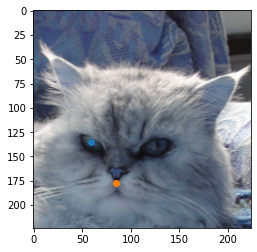

In [11]:
plt.imshow(raw_x[0])
plt.scatter(raw_y[0][0],raw_y[0][1]) #left eye
plt.scatter(raw_y[0][2],raw_y[0][3]) #right eye 
plt.scatter(raw_y[0][4],raw_y[0][5]) # nose 

In [13]:
print(raw_x.shape,raw_y.shape)

(300, 224, 224, 3) (300, 18)


# 데이터 전처리 
- normalization 
- 데이터 분할 : 눈, 코 데이터만 
- train, test 분리 

In [44]:
# normalization, y축 데이터 분리 
x = raw_x/255.
y = raw_y[:,0:6]/255. # 눈 코 데이터만 분할 

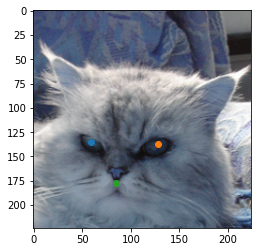

In [22]:
plt.imshow(x[0])
plt.scatter(y[0][0],y[0][1]) #left eye
plt.scatter(y[0][2],y[0][3]) #right eye 
plt.scatter(y[0][4],y[0][5]) # nose 

In [45]:
# 데이터 분리 
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y)

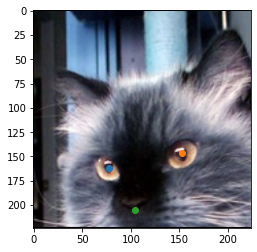

In [26]:
# 데이터 분리 확인 
plt.imshow(train_x[0])
plt.scatter(train_y[0][0],train_y[0][1])
plt.scatter(train_y[0][2],train_y[0][3])
plt.scatter(train_y[0][4],train_y[0][5])

# 모델링 
- 경우의 수 
  - y 값을 정규화 하냐 안하냐 
  - sigmoid 사용 유무 
  - 전이 모델 : vgg16 or mobilenet 

- y값을 정규화 안하는 경우 
  - vgg16 모델 : loss: 67.6522 - val_loss: 194.0872
  - mobilenet : loss: 103.0387 - val_loss: 213.5373 

  - 각 모델에 sigmoid 추가 
  - vgg16 : oss: 19756.0078  val_loss: 19732.4023 

- y값에 /255. 를 하는 경우 
  - vgg16 : loss: 5.6402e-04 - mae: 0.0181 - val_loss: 0.0047 - val_mae: 0.0439
  - mobile : loss: 8.3543e-04 - mae: 0.0222 - val_loss: 0.0052 - val_mae: 0.0520

  
  y 값에 /255 한 뒤에 vgg 16을 사용한 것이 우선은 loss 가 가장 적게 나옴 

  다만 회전 되어 있는 사진의 경우 정확도가 떨어짐 

In [32]:
train_y.shape

(225, 6)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_13 (Dense)            (None, 128)               3211392   
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 6)                 774       
                                                                 
Total params: 17,927,366
Trainable params: 3,212,422
Non-trainable params: 14,714,944
__________________________________

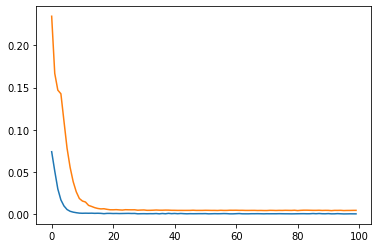

In [46]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16


conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6,activation = 'sigmoid')) #분류 문제에서는 activation = 'softmax'를 하지만 이건 예측 문제니까 사용하지 않음 

model.summary()

model.compile(optimizer='Adam', loss='mse',metrics = ['mae'])


history = model.fit(train_x, train_y, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()




Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_8 (Flatten)         (None, 62720)             0         
                                                                 
 dense_15 (Dense)            (None, 128)               8028288   
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 6)                 774       
                                                                 
Total params: 10,287,558
Trainable params: 8,029,318
N

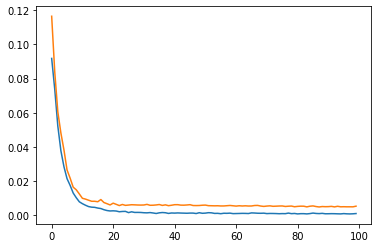

In [47]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import models
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import mobilenet_v2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#여기서의 전이 모델 : MobileNetV2
conv_layers = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

mobile_model = models.Sequential()

mobile_model.add(conv_layers)
mobile_model.add(Flatten())
mobile_model.add(Dense(128, activation='relu'))
mobile_model.add(BatchNormalization())
mobile_model.add(Dense(6,activation = 'sigmoid')) #분류 문제에서는 activation = 'softmax'를 하지만 이건 예측 문제니까 사용하지 않음 

mobile_model.summary()

mobile_model.compile(optimizer='Adam', loss='mse',metrics = ['mae'])


history = mobile_model.fit(train_x, train_y, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


# 예측 

In [50]:
y_ = model.predict(test_x)
y_ = y_ *255

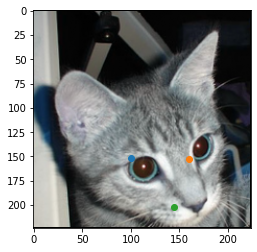

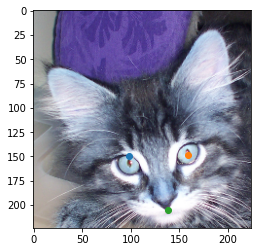

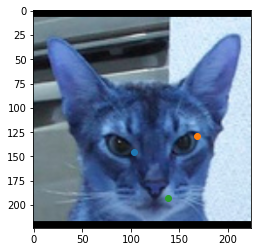

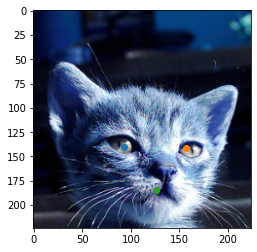

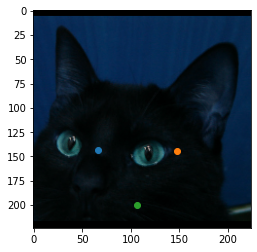

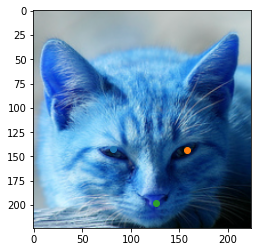

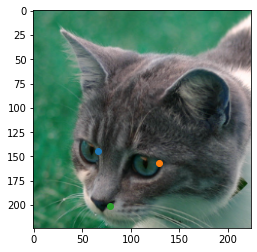

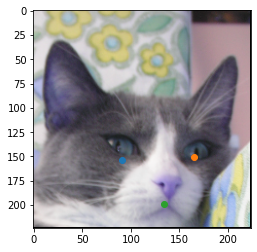

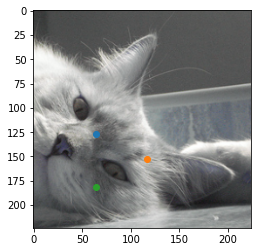

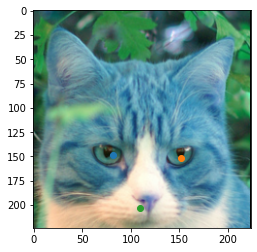

In [55]:
for i in range(10):
  plt.imshow(test_x[i])
  plt.scatter(int(y_[i][0]),int(y_[i][1]))
  plt.scatter(int(y_[i][2]),int(y_[i][3]))
  plt.scatter(int(y_[i][4]),int(y_[i][5]))
  plt.show()